# Task1Q1: Data Preprocessing - Noise Removal

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

**step 0: load data**

In [15]:
# Load news data from xlsx
df = pd.read_excel('../data/News.xlsx')
print('News.xlsx has been successfully loaded.')

# Load  A-share listed company information from json
with open('../data/A_share_list.json', 'r',encoding='utf-8') as f:
    companies = json.load(f)
print('\nA_share_list.json has been successfully loaded.')

News.xlsx has been successfully loaded.

A_share_list.json has been successfully loaded.


In [ ]:
# Check
df.head(10)

,NewsID,Title,NewsContent,NewsSource
0,1,建设银行原董事长张恩照一审被判15年,本报记者 田雨 李京华 中国建设银行股份有限公司原董事长张恩照受贿案３日一审宣...,中国证券报
1,2,农行信用卡中心搬到上海滩,中国农业银行信用卡中心由北京搬到上海了！ 农行行长杨明生日前在信用卡中心揭牌仪式上...,人民日报
2,3,外运发展：价值型蓝筹股补涨要求强烈,在新基金快速发行以及申购资金回流的情况下，市场总体上呈现资金流动性过剩格局，考虑到现阶段...,杭州新希望
3,4,胜利股份：稳步走强形成标准上升通道,胜利股份（000407）公司子公司填海造地2800亩，以青岛的地价估算，静态价值在10亿...,源达投资
4,5,[港股快讯]恒指收市报18960点 成交467亿港元,全景网11月30日讯 外围股市造好，带动港股今早造好，恒指高开后反覆上升，最高升252点...,全景网
5,6,泰信基金高清海:消费类公司具有长期增值前景,11月20日，沪市成功站上2000点大关，这是自2001年7月30日最高见2056.77...,深圳特区报
6,7,新财富分析师指数大涨3.42% 继续大幅跑赢大盘,全景网11月30日讯 在蓝筹股全线发力的推动下，周四股市表现强劲，其中新财富分析师指数更...,全景网
7,8,"南风化工：钾肥三雄之一 被""中化""相中",由于全球最大的俄罗斯Uralkaly钾矿被淹，产量大减，同时满洲里口岸铁路在修复线，导致...,银河证券
8,9,红茶馆：人民币狂升值 股市牛气冲天,如何来形容当下的股市，相信红茶馆里的茶客们都会异口同声道：“牛！”那为什么会这么牛呢？有...,国泰君安
9,10,招商轮船上市定位简析 运行区间5-6元,招商局能源运输股份有限公司A股于12月1日上市流通，证券简称为“招商轮船”，证券代码60...,金通证券


**step 1: we first try to use a simple dictionary method.**

In [ ]:
# Fill in the vacancy in NewsContent with Title
df['NewsContent'] = df['NewsContent'].fillna(df['Title'])

# Remove prefix and suffix in certain A-share listed company name
for company in companies:
    if company['name'].startswith('*ST'):
        company['shortname'] = company['name'].replace('*ST', '')
    elif company['name'].startswith('ST'):
        company['shortname'] = company['name'].replace('ST', '')
    elif company['name'].startswith('S'):
        company['shortname'] = company['name'].replace('S', '')
    elif company['name'].startswith('S*ST'):
        company['shortname'] = company['name'].replace('S*ST', '')
    elif company['name'].startswith('PT'):
        company['shortname'] = company['name'].replace('PT', '')
    elif company['name'].endswith('B股'):
        company['shortname'] = company['name'].replace('B股', '')
    elif company['name'].endswith('B退'):
        company['shortname'] = company['name'].replace('B退', '')
    elif company['name'].endswith('B'):
        company['shortname'] = company['name'].replace('B', '')
    elif company['name'].endswith('A'):
        company['shortname'] = company['name'].replace('A', '')
    elif company['name'].endswith('退'):
        company['shortname'] = company['name'].replace('退', '')
    else:
        company['shortname'] = company['name']

for company in companies:
    if len(company['shortname'])==2:
        company['shortname'] = company['name']
        
# Function to check if news contains any A-share listed company name
def get_company_name(news):
    company_names = []
    for company in companies:
        if company['shortname'] in news or company['fullname'] in news:
            company_names.append(company['name'])
    return ','.join(company_names) if company_names else None

# Apply the function to the news column
df['Explicit_Company'] = df['NewsContent'].apply(get_company_name)

# Filter rows where company_name is not null
df_filtered = df[df['Explicit_Company'].notnull()]

# Save the filtered data to a new xlsx file
df_filtered.to_excel('../data/filtered_by_step1.xlsx', encoding='utf-8', index=False)

print('completed')

/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


completed


In [16]:
# Check amount of filtered news
df_filtered.shape[0]#462464

462464

However, news articles may not always provide companies’ full names. So, we should find the companies may have abbrevatations as much as possible.

**step 2:analyze which companies will have additional abbrevatations**

Based on experience, stock names with two or three characters usually do not have more concise titles, while those with five or more characters are usually not more concise without ensuring recognition. Therefore, we assumed that we should focus on the abbreviation of the company with four character stocks.

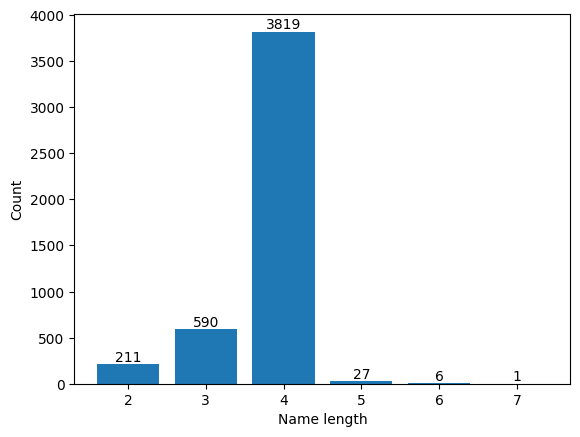

In [ ]:
import matplotlib.pyplot as plt

# Count the company name length
two_words, three_words, four_words, five_words, six_words, seven_words = 0, 0, 0, 0, 0, 0

for company in companies:
    if len(company['shortname']) == 4:
        four_words+=1
    elif len(company['shortname']) == 3:
        three_words+=1
    elif len(company['shortname']) == 2:
        two_words+=1
    elif len(company['shortname']) == 5:
        five_words+=1
    elif len(company['shortname']) == 6:
        six_words+=1
    elif len(company['shortname']) == 7:
        seven_words+=1

# Draw a bar chart
x = ['2', '3', '4', '5', '6', '7']
y = [two_words, three_words, four_words, five_words, six_words, seven_words]
for i, v in enumerate(y):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.bar(x, y)
plt.xlabel('Name length')
plt.ylabel('Count')
plt.show()

Next, let's verify the above conjecture. We know that the stock name is also the abbreviation of the company to a large extent. If the stock is already the abbreviation of the company, it is very unlikely that the company will have another abbreviation (but it cannot be excluded that the more famous companies will omit the regional prefix, for example, Maotai refers to Kweichow Moutai). So we check if the stock name is part of the company's full name to determine which companies need to consider other names.

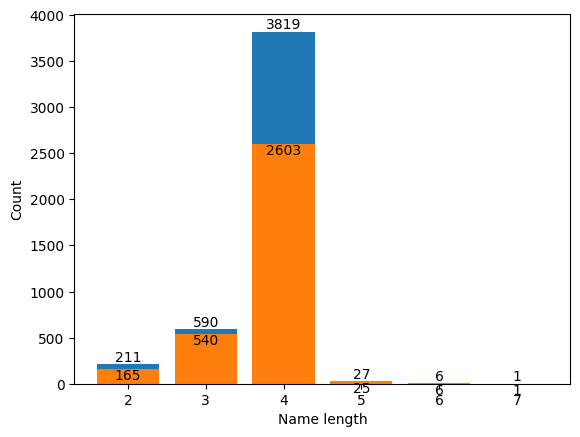

In [ ]:
# Count the number of company name included in its fullname
each_abbreviation_count = []
for i in range(2, 8):
    abbreviation_count = 0
    for company in companies:
        if len(company['shortname'])== i:
            if company['shortname'] in company['fullname']:
                abbreviation_count+=1
    each_abbreviation_count.append(abbreviation_count)

# Draw a bar chart
x = ['2', '3', '4', '5', '6', '7']
y = [two_words, three_words, four_words, five_words, six_words, seven_words]
#abb_precent = [a / b for a, b in zip(each_abbreviation_count, y)]

for i, v in enumerate(y):
    plt.text(i, v, str(v), ha='center', va='bottom')
for j, w in enumerate(each_abbreviation_count):
    plt.text(j, w, str(w), ha='center', va='top')
plt.bar(x, y, label='total')
plt.bar(x, each_abbreviation_count, label='no more abbreviation')
plt.xlabel('Name length')
plt.ylabel('Count')
plt.show()

We can see that except for the four character names, only 98 companies need to supplement their abbreviations, and we can find them and observe who are they.

In [ ]:
# Add abbname into dictionary
for company in companies:
    company['abbname'] = '初始简称'

In [ ]:
# Find all non-4 characters stock name which is not a part of its fullnmae
for company in companies:
    if len(company['shortname']) != 4:
        if company['shortname'] not in company['fullname']:
            print(company['shortname'],company['fullname'])

甘咨询 甘肃工程咨询集团股份有限公司
南华 广州大通资源开发股份有限公司
国重装 国机重型装备集团股份有限公司
深基地 深圳赤湾石油基地股份有限公司
深桑达 深圳市桑达实业股份有限公司
粤金曼 广东金曼集团股份有限公司
深赛格 深圳赛格股份有限公司
粤宏远 东莞宏远工业区股份有限公司
粤高速 广东省高速公路发展股份有限公司
深高速 深圳高速公路股份有限公司
宁通信 南京普天通信股份有限公司
电科院 苏州电器科学研究院股份有限公司
东电 浙江东南发电股份有限公司
锦旅 上海锦江国际旅游股份有限公司
上航 上海航空股份有限公司
上普 上海普天邮通科技股份有限公司
京天利 北京无线天利移动信息技术股份有限公司
深天地 深圳市天地(集团)股份有限公司
神城 神州长城股份有限公司
慧业 江苏农华智慧农业科技股份有限公司
荣联 北京荣之联科技股份有限公司
建科院 深圳市建筑科学研究院股份有限公司
粤华包 佛山华新包装股份有限公司
本实 深圳本鲁克斯实业股份有限公司
鑫光 珠海金马控股股份有限公司
龙科 黑龙江省科利华网络股份有限公司
哈高科 哈尔滨高科技(集团)股份有限公司
瓦轴 瓦房店轴承股份有限公司
鞍成 鞍山合成(集团)股份有限公司
鞍一工 辽宁华夏大地生态技术股份有限公司
西发 西藏银河科技发展股份有限公司
中川 中国四川国际合作股份有限公司
兰铝 兰州铝业股份有限公司
中葡 中信国安葡萄酒业股份有限公司
中绒 宁夏中银绒业股份有限公司
琼民源 海南民源现代农业发展股份有限公司
粤电力 广东电力发展股份有限公司
深深房 深圳经济特区房地产(集团)股份有限公司
深天马 天马微电子股份有限公司
深纺织 深圳市纺织(集团)股份有限公司
深中华 深圳中华自行车(集团)股份有限公司
深大通 深圳大通实业股份有限公司
深科技 深圳长城开发科技股份有限公司
深康佳 康佳集团股份有限公司
深振业 深圳市振业(集团)股份有限公司
深物业 深圳市物业发展(集团)股份有限公司
穗恒运 广州恒运企业集团股份有限公司
建研院 苏州市建筑科学研究院集团股份有限公司
炎黄 江苏高能时代在线股份有限公司
杭汽轮 杭州汽轮机股份有限公司
沪科 上海宽频科技股份有限公司
哈三联 哈尔滨三联药业股份有限公司
工新 哈尔滨工大高新技术产业开发股份有限公司
华源 华电能源股份有限公司
哈空调 哈尔滨空调股份有限

An obvious rule can be found in the full names of these companies: all companies end with '有限公司', and companies that start with '中国' or foreign subsidiaries in China with '(中国)' are generally state-owned or well-known enterprises. Removing '中国' will not create ambiguity. So we will remove '中国','（）','有限'，'公司','集团'，'控股'，'股份' from the full name.

In [ ]:
# Remove the specified words from the abbname field of each company in the companies list
remove_word_non4 = ['中国', '有限', '公司', '集团', '控股', '股份', '(', ')','（', '）']
for company in companies:
    if len(company['shortname']) != 4:
        if company['shortname'] not in company['fullname']:
            company['abbname'] = company['fullname']
            for word_non4 in remove_word_non4:
                company['abbname'] = company['abbname'].replace(word_non4, '')
print('done')

done


For companies with four words, the above rules may not apply because many large companies have many listed subsidiaries, and '集团', '控股', '股份' are used to distinguish them. Therefore, we modify the rules: if these three words are not present in the stock name, the corresponding words will be deleted.

In [ ]:
# Remove the specified words from the abbname field of each company in the companies list
remove_word4_all = ['中国', '有限', '公司', '(', ')','（', '）']
remove_word4_certain = ['集团', '控股', '股份']
for company in companies:
    if len(company['shortname']) == 4:
        if company['shortname'] not in company['fullname']:
            company['abbname'] = company['fullname']
            # Remove these words for all of companies
            for word4_all in remove_word4_all:
                company['abbname'] = company['abbname'].replace(word4_all, '')
            # Remove these words for companies not have them in stock name
            for word4_certain in remove_word4_certain:
                if word4_certain not in company['shortname']:
                    company['abbname'] = company['abbname'].replace(word4_certain, '')
print('done')

done


**step 3: optimize the dictionary method by applying abbreviation we defined above**

Finally, we add some common company abbreviations based on knowledge and then processing data again.

In [ ]:
# Manually add some special abbrevaitions
for company in companies:
    if company['name'] == '贵州茅台':
        company['abbname'] = '茅台'
    elif company['name'] == '中国银行':
        company['abbname'] = '中行'
    elif company['name'] == '工商银行':
        company['abbname'] = '工行'
    elif company['name'] == '建设银行':
        company['abbname'] = '建行'
    elif company['name'] == '农业银行':
        company['abbname'] = '农行'
    elif company['name'] == '交通银行':
        company['abbname'] = '交行'
    elif company['name'] == '中国石油':
        company['abbname'] = '中石油'
    elif company['name'] == '中国石化':
        company['abbname'] = '中石化'
    elif company['name'] == '南方航空':
        company['abbname'] = '南航'
    elif company['name'] == '海南航空':
        company['abbname'] = '海航'

In [17]:
# Fill in the vacancy in NewsContent with Title
df['NewsContent'] = df['NewsContent'].fillna(df['Title'])

# Remove prefix and suffix in certain A-share listed company name
for company in companies:
    if company['name'].startswith('*ST'):
        company['shortname'] = company['name'].replace('*ST', '')
    elif company['name'].startswith('ST'):
        company['shortname'] = company['name'].replace('ST', '')
    elif company['name'].startswith('S'):
        company['shortname'] = company['name'].replace('S', '')
    elif company['name'].startswith('S*ST'):
        company['shortname'] = company['name'].replace('S*ST', '')
    elif company['name'].startswith('PT'):
        company['shortname'] = company['name'].replace('PT', '')
    elif company['name'].endswith('B股'):
        company['shortname'] = company['name'].replace('B股', '')
    elif company['name'].endswith('B退'):
        company['shortname'] = company['name'].replace('B退', '')
    elif company['name'].endswith('B'):
        company['shortname'] = company['name'].replace('B', '')
    elif company['name'].endswith('A'):
        company['shortname'] = company['name'].replace('A', '')
    elif company['name'].endswith('退'):
        company['shortname'] = company['name'].replace('退', '')
    else:
        company['shortname'] = company['name']

for company in companies:
    if len(company['shortname'])==2:
        company['shortname'] = company['name']
        
# Function to check if news contains any A-share listed company name
def get_company_name(news):
    company_names = []
    for company in companies:
        if company['shortname'] in company['fullname']:
            if company['abbname'] == '初始简称':
                if company['code'] in news or company['shortname'] in news:
                    company_names.append(company['name'])
            else:
                if company['code'] in news or company['shortname'] in news or company['abbname'] in news:
                    company_names.append(company['name'])
        else:
            if company['code'] in news or company['shortname'] in news or company['fullname'] in news or company['abbname'] in news:
                company_names.append(company['name'])
    return ','.join(company_names) if company_names else None

# Apply the function to the news column
df['Explicit_Company'] = df['NewsContent'].apply(get_company_name)

# Filter rows where company_name is not null
df_filtered = df[df['Explicit_Company'].notnull()]

# Save the filtered data to a new xlsx file
df_filtered.to_excel('../data/filtered_by_step2.xlsx', encoding='utf-8', index=False)

print('completed\n')
print(df_filtered.shape[0])

completed

495149


# Task1Q2: Data Analysis - Text Knowledge Mining

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import time
from datetime import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split

We first reprocess the previously filtered data, first deleting unnecessary columns, and then considering the impact of news length, we shuffled the data according to length and then evenly divide it into five parts.

In [ ]:
# Load the dataframe and remove column we don't need
df_filtered = pd.read_excel('../data/filtered_by_step2.xlsx')
df_filtered = df_filtered.drop(['Title','NewsSource'], axis=1)
df_filtered.head()

,NewsID,NewsContent,Explicit_Company
0,1,本报记者 田雨 李京华 中国建设银行股份有限公司原董事长张恩照受贿案３日一审宣...,建设银行
1,2,中国农业银行信用卡中心由北京搬到上海了！ 农行行长杨明生日前在信用卡中心揭牌仪式上...,"中金公司, 农业银行"
2,3,在新基金快速发行以及申购资金回流的情况下，市场总体上呈现资金流动性过剩格局，考虑到现阶段...,"外运发展, 中国国航"
3,4,胜利股份（000407）公司子公司填海造地2800亩，以青岛的地价估算，静态价值在10亿...,"生物, 胜利股份"
4,5,全景网11月30日讯 外围股市造好，带动港股今早造好，恒指高开后反覆上升，最高升252点...,"高升, 交通银行, 建设银行, 中国银行, 工商银行"


In [ ]:
# Shuffle the dataframe based on news length
df_filtered['length'] = df_filtered['NewsContent'].apply(len)
df_filtered = df_filtered.sort_values(by='length')
df_filtered = df_filtered.drop(['length'], axis=1)
shuffled_df = df_filtered.sample(frac=1).reset_index(drop=True)

# Split DataFrame into 5
n = len(shuffled_df) // 5  # Calculate the number of rows for each group
remainder = len(shuffled_df) % 5  # Calculate the number of remaining rows

df_parts = []
start = 0
for i in range(5):
    if i < remainder:
        end = start + n + 1
    else:
        end = start + n
    part = shuffled_df[start:end]
    df_parts.append(part)
    start = end

for i, part_i in enumerate(df_parts):
    part_i.to_excel('../data/processing_data/shuffled_part{}.xlsx'.format(i), encoding='utf-8', index=False)

/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


Next, we will access Baidu's API to label the data. We will label two small datasets as training and testing sets, respectively.

In [ ]:
!pip install baidu-aip

In [ ]:
from aip import AipNlp

# Input APPID AK SK
APP_ID = ''
API_KEY = ''
SECRET_KEY = ''

client = AipNlp(APP_ID, API_KEY, SECRET_KEY)


# To split the string since api have length limitation
def split_string(string, max_length):
    result = []
    while len(string) > max_length:
        result.append(string[:max_length])
        string = string[max_length:]
    result.append(string)
    return result

# Define a function to classify sentiment
def sentiment_analyze(text):
    if len(text) < 2048:
        dict_result = client.sentimentClassify(text)
        senti_prob = dict_result['items'][0]['positive_prob']
    else:
        senti_prob = 0
        split_list = split_string(text, 2048)
        for i in range(len(split_list)):
            dict_result = client.sentimentClassify(split_list[i])
            senti_prob += dict_result['items'][0]['positive_prob']

        senti_prob = senti_prob/len(split_list)

    return senti_prob



Because calling Baidu's API has saved us a lot of time dealing with tedious problems, the main task now is to ensure that it can work properly. Due to the large amount of data and the inability to guarantee the stability of the interface, we use exception capture to ensure that QPS does not exceed the limit. And set a certain amount, when the number of tags is sufficient, it will be saved first to prevent the program from getting any results in case of errors. Most importantly, due to the long running time, this code can be terminated at any time, and the next run will start from the termination point.

In [ ]:
# Load data
parti = 1 #Change this to which part you want to load
df_shuffled = pd.read_excel('../data/processing_data/shuffled_part{}.xlsx'.format(parti))

# Define
labellist = []
num_save = 2000 #Can be changed
save_i = 58 #If the code interrupted this can change

In [ ]:
# A version without tqdm: df_parts[0]['label'] = df_parts[0]['NewsContent'].apply(client.sentimentClassify)['items'][0]['positive_prob']

#pbar.close() # If interrupted doing this
# Create a tqdm
pbar = tqdm(total=len(df_shuffled)-save_i*num_save-len(labellist))

# For each row
for index, row in df_shuffled[save_i*num_save+len(labellist):].iterrows():
    my_dict = {}
    # Avoid QPS exceed the limit
    time.sleep(0.1)
    # Use the function to classify sentiment
    try:
        my_dict['NewsID'] = row['NewsID']
        my_dict['label'] = sentiment_analyze(row['NewsContent'])
        labellist.append(my_dict)
    except:
        time.sleep(1)
        my_dict['NewsID'] = row['NewsID']
        my_dict['label'] = sentiment_analyze(row['NewsContent'])
        labellist.append(my_dict)

    # When length reach num_save save the label list
    if len(labellist) == num_save:
        with open('../data/label_by_baidu/labeled_part{}_{}.json'.format(parti, save_i), 'w') as f:
            json.dump(labellist, f)

        labellist = []
        save_i += 1

    # Update tqdm
    pbar.update(1)

pbar.close()

# Save the final one
with open('../data/label_by_baidu/labeled_part{}_{}.json'.format(parti, save_i), 'w') as f:
    json.dump(labellist, f)

print('completed')

100%|██████████| 778/778 [09:52<00:00,  1.31it/s]

completed


In above, we divided the obtained labels into many small parts to save. Next, we wrote these saved labels into the original dataset, so that a piece of data that can be used for training is completed.

In [ ]:
# Read json and write them into dataframe
label_df_all = pd.DataFrame(columns=['NewsID', 'label'])
for i in range(save_i+1):
    with open('../data/label_by_baidu/labeled_part{}_{}.json'.format(parti, i), 'r') as f:
        label_dict = json.load(f)
    label_df = pd.DataFrame(label_dict)
    label_df_all = pd.concat([label_df_all, label_df])

df_shuffled_labeled = df_shuffled.merge(label_df_all, on='NewsID', how='left')
print('completed')

completed


In [ ]:
# Check
null_rows = df_shuffled_labeled[df_shuffled_labeled['label'].isnull()]
print(null_rows)

Empty DataFrame
Columns: [NewsID, NewsContent, Explicit_Company, label]
Index: []


In [ ]:
# Save the labeled df
df_shuffled_labeled.to_excel('../data/processing_data/labeled_part{}.xlsx'.format(parti), encoding='utf-8', index=False)
print('completed')

/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


completed


Next, we will train a model using the previously classified data. The classification model we use, BertForSequenceClassification, is based on BertModel by adding a linear layer and activation function for classification. The pre trained model Bert base machine provided by Huggingface only includes the weights of BertModel, not the weights of linear layer and activation function. Below, we will use the method to load the model, then the weights of the linear layer and activation function will be randomly initialized. Our goal is to learn the weights of linear layers and activation functions through fine-tuning. This time we use Pytorch for training, and of course, in the additional code section, code was written use to train by the transformer's built-in trainer function.

In [2]:
!pip install transformers[torch]

                                              0.0/7.7 MB ? eta -:--:--
                                              0.0/7.7 MB ? eta -:--:--
                                              0.0/7.7 MB 330.3 kB/s eta 0:00:24
                                              0.1/7.7 MB 469.7 kB/s eta 0:00:17
                                              0.1/7.7 MB 722.1 kB/s eta 0:00:11
     -                                        0.2/7.7 MB 985.7 kB/s eta 0:00:08
     -                                        0.3/7.7 MB 1.3 MB/s eta 0:00:06
     --                                       0.5/7.7 MB 1.6 MB/s eta 0:00:05
     ---                                      0.7/7.7 MB 2.3 MB/s eta 0:00:04
     -----                                    1.0/7.7 MB 2.8 MB/s eta 0:00:03
     -------                                  1.4/7.7 MB 3.6 MB/s eta 0:00:02
     ----------                               2.0/7.7 MB 4.8 MB/s eta 0:00:02
     -------------                            2.7/7.7 MB 5.7 MB/s eta 

In [11]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_scheduler

# Hyper parameters
HIDDEN_DROPOUT_PROB = 0.3
NUM_LABELS = 2
LR = 1e-5
WEIGHT_DECAY = 1e-2
EPOCH = 5
BATCH_SIZE = 64
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# Load BERT tokenizer and model # 'hfl/chinese-bert-wwm'
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
config = BertConfig.from_pretrained('bert-base-chinese', num_labels=NUM_LABELS, hidden_dropout_prob=HIDDEN_DROPOUT_PROB)
model = BertForSequenceClassification.from_pretrained('bert-base-chinese', config=config)
model.to(device)

# Load data
df_shuffled_labeled = pd.read_excel('../data/processing_data/labeled_part1.xlsx')
texts = df_shuffled_labeled['NewsContent'].tolist()
labels = df_shuffled_labeled['label'].tolist()

class CustomDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        return text, label

# Divide training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
# Preparing the PyTorch dataset
train_dataset = CustomDataset(train_texts, train_labels)
test_dataset = CustomDataset(test_texts, test_labels)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)


# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': WEIGHT_DECAY},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

# Define optimizer and loss function
#optimizer = AdamW(model.parameters(), lr=learning_rate)
optimizer = AdamW(optimizer_grouped_parameters, lr=LR)
lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=EPOCH * len(train_dataloader))
criterion = nn.CrossEntropyLoss().to(device)
pbar = tqdm(range(EPOCH * len(train_dataloader)))

# Define the training function
def train(epoch, dataloader):
    model.train()
    epoch_acc = 0

    for idx, data in enumerate(dataloader):
        text, label = data
        label = label.to(device)

        tokenize_text = tokenizer(text, max_length=100, add_special_tokens=True, truncation=True, padding=True, return_tensors='pt')
        tokenize_text = tokenize_text.to(device)

        optimizer.zero_grad()
        output = model(**tokenize_text, labels=label)

        # y_pred_prob = logits : [batch_size, num_labels]
        y_pred_prob = output[1]
        y_pred_label = y_pred_prob.argmax(dim=1)

        # loss = loss
        loss = output[0]

        acc = ((y_pred_label == label.view(-1)).sum()).item()

        # Back Propagation
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        

        if idx % 100 == 0:
            #print(f'train epoch:{epoch+1}, loss: {loss}')

            now = datetime.now()
            now = now.strftime('%Y-%m-%d %H:%M:%S')

            content = f'{now}\tloss: {loss}\n'

            with open('../model/information.txt', 'a+', encoding='utf-8') as file:
                file.write(content)

        epoch_acc += acc
        pbar.update(1)

    accuracy = epoch_acc / len(train_dataset)

    print(f'Accuracy on the training set: {accuracy:.4f}')

    now = datetime.now()
    now = now.strftime('%Y-%m-%d %H:%M:%S')

    content = f'{now}\tAccuracy on the training set: {accuracy:.4f}\n'

    with open('../model/information.txt', 'a+', encoding='utf-8') as file:
        file.write(content)

# Define the validation function
def validate(epoch, dataloader):
    model.eval()

    total_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for _, data in enumerate(dataloader):
            text, label = data
            label = label.to(device)

            tokenize_text = tokenizer(text, max_length=100, padding=True, truncation=True, add_special_tokens=True, return_tensors='pt')
            tokenize_text = tokenize_text.to(device)

            output = model(**tokenize_text, labels=label)

            y_pred_label = output[1].argmax(dim=1)
            loss = output[0]

            total_loss += loss

            acc = (y_pred_label == label.view(-1)).sum().item()
            epoch_acc += acc

    print(f'Loss on the test set: {total_loss}')

    accuracy = epoch_acc / len(test_dataset)
    print(f'Accuracy on the test set: {accuracy}')

    torch.save(model.state_dict(), f'../model/bertbasechinese_classification_epoch{epoch+1}.pth')
    print('Model saved')

    now = datetime.now()
    now = now.strftime('%Y-%m-%d %H:%M:%S')

    content = f'{now}\tLoss on the test set: {total_loss}，Accuracy on the test set: {accuracy}\n'
    with open('../model/information.txt', 'a+', encoding='utf-8') as file:
        file.write(content)


for i in range(EPOCH):
    content = f"{'-' * 20}epoch{i + 1}{'-' * 20}\n"

    content = content + f"{'*' * 10}训练开始{'*' * 10}\n"

    with open('../model/information.txt', 'a+', encoding='utf-8') as file:
        file.write(content)

    train(i, train_dataloader)

    content = f"{'*' * 10}测试开始{'*' * 10}\n"

    with open('../model/information.txt', 'a+', encoding='utf-8') as file:
        file.write(content)

    validate(i, test_dataloader)

pbar.close()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Lee\miniconda3\envs\p5002\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 20%|██        | 1464/7320 [07:47<36:16,  2.69it/s]

Accuracy on the training set: 0.8206
Loss on the test set: 128.35208129882812
Accuracy on the test set: 0.8437366578430535
Model saved


 40%|████      | 2928/7320 [18:40<27:28,  2.66it/s]   

Accuracy on the training set: 0.8470
Loss on the test set: 130.08409118652344
Accuracy on the test set: 0.8453163692255145
Model saved


 60%|██████    | 4392/7320 [29:31<17:47,  2.74it/s]   

Accuracy on the training set: 0.8546
Loss on the test set: 124.93095397949219
Accuracy on the test set: 0.8515071300486722
Model saved


 80%|████████  | 5856/7320 [38:59<06:47,  3.59it/s]   

Accuracy on the training set: 0.8640
Loss on the test set: 127.18487548828125
Accuracy on the test set: 0.8521475535821023
Model saved


100%|██████████| 7320/7320 [47:07<00:00,  3.57it/s]  

Accuracy on the training set: 0.8678
Loss on the test set: 126.11343383789062
Accuracy on the test set: 0.854666552813594


100%|██████████| 7320/7320 [48:04<00:00,  2.54it/s]

Model saved


Test the models on another labeled dataset.

In [13]:
# Load model we have trained
model.load_state_dict(torch.load('../model/bertbasechinese_classification_epoch3.pth'))
model.eval()

# Load dataset
labeling_df = pd.read_excel('../data/processing_data/labeled_part0.xlsx')
texts = labeling_df['NewsContent'].tolist()
labels = labeling_df['label'].tolist()
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        
        return text

dataset = TextDataset(texts)
dataloader = DataLoader(dataset=dataset, batch_size=64, shuffle=False, num_workers=0)

y_label = []
pbar = tqdm(range(len(dataloader)))

# Test model
with torch.no_grad():
        for _, text in enumerate(dataloader):

            tokenize_text = tokenizer(text, max_length=100, padding=True, truncation=True, add_special_tokens=True, return_tensors='pt')
            tokenize_text = tokenize_text.to(device)

            output = model(**tokenize_text)
            y_pred_label = torch.argmax(output.logits, dim=1)
            y_label.append(y_pred_label)
            pbar.update(1)
            
pbar.close()

# Convert tensor into list
y_label_list = []
for label in y_label:
    y_label_list.extend(label.tolist())

# Calculate accuracy    
acc=0
for i in range(len(labels)):
    if labels[i]==y_label_list[i]:
        acc+=1
        
print(acc/len(labels))

100%|██████████| 1830/1830 [02:56<00:00, 10.38it/s]


0.8501285149478682


After completing the training, we found the best performing model in the saved model to complete the text classification task. The following is the code:

In [7]:
# Load model we have trained
model.load_state_dict(torch.load('../model/bertbasechinese_classification_epoch4.pth'))
model.eval()

# Load dataset we need to label
labeling_df = pd.read_excel('../data/processing_data/shuffled_part4.xlsx')
texts = labeling_df['NewsContent'].tolist()
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        
        return text

dataset = TextDataset(texts)
dataloader = DataLoader(dataset=dataset, batch_size=64, shuffle=False, num_workers=0)

# Run model
y_label = []
pbar = tqdm(range(len(dataloader)))
with torch.no_grad():
        for _, text in enumerate(dataloader):

            tokenize_text = tokenizer(text, max_length=100, padding=True, truncation=True, add_special_tokens=True, return_tensors='pt')
            tokenize_text = tokenize_text.to(device)

            output = model(**tokenize_text)
            y_pred_label = torch.argmax(output.logits, dim=1)
            y_label.append(y_pred_label)
            pbar.update(1)
            
pbar.close()

# Convert tensor into list
y_label_list = []
for label in y_label:
    y_label_list.extend(label.tolist())
 
# Save result   
labeling_df['label'] = y_label_list
labeling_df.to_excel('../data/processing_data/labeled_part4.xlsx', encoding='utf-8', index=False)

100%|██████████| 1830/1830 [04:34<00:00,  6.67it/s]
C:\Users\Lee\miniconda3\envs\p5002\lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


Integrate the partially labeled data into a complete one.

In [10]:
# Read Excel files and merge them into df_ Merged 
df_labeled_part0 = pd.read_excel('../data/processing_data/labeled_part0.xlsx')
df_labeled_part1 = pd.read_excel('../data/processing_data/labeled_part1.xlsx')
df_labeled_part2 = pd.read_excel('../data/processing_data/labeled_part2.xlsx')
df_labeled_part3 = pd.read_excel('../data/processing_data/labeled_part3.xlsx')
df_labeled_part4 = pd.read_excel('../data/processing_data/labeled_part4.xlsx')

df_labeled_merged = pd.concat([df_labeled_part0, df_labeled_part1, df_labeled_part2, df_labeled_part3, df_labeled_part4])
# Arrange by NewsID
df_labeled_merged.sort_values('NewsID', inplace=True)

# Save the merged data to a new Excel file  
df_labeled_merged.to_excel("../result/Task1.xlsx", encoding='utf-8',  index=False)

C:\Users\Lee\miniconda3\envs\p5002\lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


# Additional Code

In addition to using Baidu's API, we can also use Alibaba's

In [ ]:
!pip install aliyun-python-sdk-alinlp==1.0.20

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.0/443.0 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for aliyun-python-sdk-core: filename=aliyun_python_sdk_core-2.14.0-py3-none-any.whl size=535290 sha256=5c6c69a3f7f98f621234d502e66122cb936581b5580727bc672cbce427912af0
  Stored in directory: /root/.cache/pip/wheels/16/3c/68/b7eab618d9f1d5e7d386296f1e07e2cf36aaa1eb5161885038
Successfully built aliyun-python-sdk-core


In [ ]:
from aliyunsdkalinlp.request.v20200629 import GetSaChGeneralRequest

from aliyunsdkcore.client import AcsClient
from aliyunsdkcore.acs_exception.exceptions import ClientException
from aliyunsdkcore.acs_exception.exceptions import ServerException

access_key_id = ''
access_key_secret = ''
# Create AcsClient
client = AcsClient(
    access_key_id,
    access_key_secret,
    'cn-hangzhou'
)

# To split the string since api have length limitation
def split_string(string, max_length):
    result = []
    while len(string) > max_length:
        result.append(string[:max_length])
        string = string[max_length:]
    result.append(string)
    return result

# Define a function to classify sentiment
def sentiment_analyze_ali(text):
    request = GetSaChGeneralRequest.GetSaChGeneralRequest()
    request.set_Text(text)
    request.set_ServiceCode("alinlp")
    response = client.do_action_with_exception(request)
    resp_obj = json.loads(response)
    if len(text) < 1000:
        request = GetSaChGeneralRequest.GetSaChGeneralRequest()
        request.set_Text(text)
        request.set_ServiceCode("alinlp")
        response = client.do_action_with_exception(request)
        resp_obj = json.loads(response)
        dict_result = json.loads(resp_obj['Data'])
        senti_prob = dict_result["result"]["positive_prob"]

    else:
        senti_prob = 0
        split_list = split_string(text, 1000)
        for i in range(len(split_list)):
            request = GetSaChGeneralRequest.GetSaChGeneralRequest()
            request.set_Text(split_list[i])
            request.set_ServiceCode("alinlp")
            response = client.do_action_with_exception(request)
            resp_obj = json.loads(response)
            dict_result = json.loads(resp_obj['Data'])
            senti_prob += dict_result["result"]["positive_prob"]

        senti_prob = senti_prob/len(split_list)

    return senti_prob



In [ ]:
# Load data
df_shuffled_0 = pd.read_excel('/content/drive/MyDrive/data5002/label_by_baidu/shuffled_part0.xlsx')

# Define
labellist_0 = []
num_save = 2000 #Can be changed
save_i = 0 #If the code interrupted this can change

In [ ]:
# pbar.close() # If interrupted doing this
# Create a tqdm
pbar = tqdm(total=len(df_shuffled_0)-save_i*num_save-len(labellist_0))

# For each row
for index, row in df_shuffled_0[save_i*num_save+len(labellist_0):].iterrows():
    my_dict = {}
    # Avoid QPS exceed the limit
    time.sleep(0.1)
    # Use the function to classify sentiment
    try:
        my_dict['NewsID'] = row['NewsID']
        my_dict['label'] = sentiment_analyze_ali(row['NewsContent'])
        labellist_0.append(my_dict)
    except:
        time.sleep(1)
        my_dict['NewsID'] = row['NewsID']
        my_dict['label'] = sentiment_analyze_ali(row['NewsContent'])
        labellist_0.append(my_dict)

    #When length reach num_save save the label list
    if len(labellist_0) == num_save:
        with open('/content/drive/MyDrive/data5002/label_by_baidu/labeledbyali_part0_{}.json'.format(save_i), 'w') as f:
            json.dump(labellist_0, f)

        labellist_0 = []
        save_i += 1

    # Update tqdm
    pbar.update(1)

pbar.close()

In addition to using pytorch for training, we can also use the trainer function in the transformer library

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Load data
df_shuffled_labeled = pd.read_excel('/content/drive/MyDrive/data5002/label_by_baidu/labeled_part0.xlsx')
texts = df_shuffled_labeled['NewsContent'][:2000].tolist()
labels = df_shuffled_labeled['label'][:2000].apply(round).tolist()

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Divide training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.9, random_state=42)

# Load pretrained BERT model and tokenizer
model_name = 'hfl/chinese-bert-wwm'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Data preprocessing
train_encodings = tokenizer(train_texts, padding=True, truncation=True, return_tensors='pt')
test_encodings = tokenizer(test_texts, padding=True, truncation=True, return_tensors='pt')

# Preparing the PyTorch dataset
train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

# Training model
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    logging_steps=200,
    report_to="tensorboard"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()
trainer.save_model()

# Evaluate model
predictions = trainer.predict(test_dataset).predictions
predicted_labels = np.argmax(predictions, axis=1)

print("Accuracy: ", accuracy_score(test_labels, predicted_labels))
print(classification_report(test_labels, predicted_labels))

SnowNLP is a powerful Chinese text processing library that includes many functions such as Chinese word segmentation, part of speech tagging, sentiment analysis, text classification, keyword/abstract extraction, TF/IDF, text similarity, etc. Algorithms such as Hidden Markov Model, Naive Bayes, TextRank, etc. have corresponding applications in this library.

In [ ]:
!pip install snownlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for snownlp: filename=snownlp-0.12.3-py3-none-any.whl size=37760945 sha256=f4b1519c23c6b954d43a941cb7b66f8b6c77b9c15b33615d7924fb8457c53a6c
  Stored in directory: /root/.cache/pip/wheels/43/f3/70/8990fc249efeb396007766676706f71dd3d1ca3c023ce522ce
Successfully built snownlp


In [ ]:
from snownlp import SnowNLP

def senti_cla(text):
    s = SnowNLP(text)
    return s.sentiments

pbar.close()
pbar = tqdm(total=len(df_parts[0]))
labellist_1 = []

for index, row in df_parts[0].iterrows():
    my_dict = {}
    # Use the function to classify sentiment

    my_dict['NewsID'] = row['NewsID']

    my_dict['label'] = senti_cla(row['NewsContent'])
    labellist_1.append(my_dict)

    pbar.update(1)

pbar.close()